# Test analysis

### Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import netCDF4
# import pandas as pd
import dask
# from mpl_toolkits.basemap import Basemap
# from datetime import datetime
# from datetime import timedelta
# from scipy import stats
# import scipy.interpolate as interp
# from dask.distributed import Client
%matplotlib inline

In [2]:
# for quantreg
# from sklearn.linear_model import QuantileRegressor
from scipy import stats

In [3]:
from functions import ccplot, binning

In [4]:
import seaborn as sns
# Use seaborn style defaults and set default figure size
# plt.style.use('seaborn-pastel')
# sns.set_theme(style="ticks")
plt.style.use(['science', 'notebook'])

In [5]:
# Colormap selection
xr.set_options(cmap_divergent='RdBu', cmap_sequential='YlGnBu')

### Import data

In [6]:
mfdata_DIR = './data/temporary/gpm*.nc'
    
gpm = xr.open_mfdataset(mfdata_DIR, chunks={'time':5000, 'lat':40, 'lon':40}, engine='netcdf4', combine='nested', concat_dim='time', parallel=True)
# gpm = xr.open_mfdataset(mfdata_DIR, engine='netcdf4', combine='nested', concat_dim='time', parallel=True)
# gpm = xr.open_dataset('./data/GPM_data/gpm_2000.nc', chunks={"time":2000})

In [7]:
gpm = gpm.unify_chunks()
gpm.chunks

Frozen({'time': (5000, 5000, 272, 5000, 5000, 5000, 2520, 5000, 5000, 5000, 2520, 5000, 5000, 5000, 2520, 5000, 5000, 5000, 2568), 'lat': (40, 40, 40, 40, 1), 'lon': (40, 40, 40, 40, 1)})

In [8]:
gpm

,Array,Chunk
Bytes,7.76 GiB,30.52 MiB
Shape,"(80400, 161, 161)","(5000, 40, 40)"
Count,955 Tasks,475 Chunks
Type,float32,numpy.ndarray


In [9]:
precip = gpm.precipCal.resample(time = '1H').mean()

/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


In [10]:
precip = precip.chunk(dict(time=5000, lat=40, lon=40))

In [11]:
precip = precip.unify_chunks()
precip.chunks

((5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 200),
 (40, 40, 40, 40, 1),
 (40, 40, 40, 40, 1))

In [12]:
precip

<xarray.DataArray 'precipCal' (time: 40200, lat: 161, lon: 161)>
dask.array<rechunk-merge, shape=(40200, 161, 161), dtype=float32, chunksize=(5000, 40, 40), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2000-06-01 ... 2004-12-31T23:00:00
  * lon      (lon) float64 60.0 60.25 60.5 60.75 61.0 ... 99.25 99.5 99.75 100.0
  * lat      (lat) float64 0.0 0.25 0.5 0.75 1.0 ... 39.0 39.25 39.5 39.75 40.0

In [13]:
mfdata_DIR2 = './data/temporary/era*.nc'

era = xr.open_mfdataset(mfdata_DIR2, chunks={'time':5000, 'lat':40, 'lon':40}, engine='netcdf4', combine='nested', concat_dim='time', parallel=True)
# era = xr.open_mfdataset(mfdata_DIR2, engine='netcdf4', combine='nested', concat_dim='time', parallel=True)

In [14]:
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    era = era.reindex(latitude = era.latitude[::-1])

In [15]:
era = era.sel(time = slice("2000-06-01 00:00:00","2004-12-31 23:00:00"))

In [16]:
era = era.unify_chunks()
era.chunks

Frozen({'time': (1352, 3784, 5000, 3760, 5000, 3760, 5000, 3760, 5000, 3784), 'latitude': (161,), 'longitude': (161,)})

In [17]:
era

<xarray.Dataset>
Dimensions:    (latitude: 161, longitude: 161, time: 40200)
Coordinates:
  * latitude   (latitude) float32 0.0 0.25 0.5 0.75 ... 39.25 39.5 39.75 40.0
  * longitude  (longitude) float32 60.0 60.25 60.5 60.75 ... 99.5 99.75 100.0
  * time       (time) datetime64[ns] 2000-06-01 ... 2004-12-31T23:00:00
Data variables:
    u10        (time, latitude, longitude) float32 dask.array<chunksize=(1352, 161, 161), meta=np.ndarray>
    v10        (time, latitude, longitude) float32 dask.array<chunksize=(1352, 161, 161), meta=np.ndarray>
    d2m        (time, latitude, longitude) float32 dask.array<chunksize=(1352, 161, 161), meta=np.ndarray>
    t2m        (time, latitude, longitude) float32 dask.array<chunksize=(1352, 161, 161), meta=np.ndarray>
    mx2t       (time, latitude, longitude) float32 dask.array<chunksize=(1352, 161, 161), meta=np.ndarray>
    mn2t       (time, latitude, longitude) float32 dask.array<chunksize=(1352, 161, 161), meta=np.ndarray>
    sst        (time, latitude, longitude) float32 dask.array<chunksize=(1352, 161, 161), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2021-10-02 12:58:09 GMT by grib_to_netcdf-2.20.0: /opt/ecmw...

In [18]:
# era = era.sel(expver=1, drop=True)

In [19]:
# era.coords['latitude'] = np.flip(era.coords['latitude']

In [20]:
era = era.transpose('time', 'latitude', 'longitude')

In [21]:
# era = era.rename_dims({'longitude':'lon', 'latitude':'lat'})

In [22]:
era = era.rename({'longitude':'lon', 'latitude':'lat'})

In [23]:
era

<xarray.Dataset>
Dimensions:  (lat: 161, lon: 161, time: 40200)
Coordinates:
  * lat      (lat) float32 0.0 0.25 0.5 0.75 1.0 ... 39.0 39.25 39.5 39.75 40.0
  * lon      (lon) float32 60.0 60.25 60.5 60.75 61.0 ... 99.25 99.5 99.75 100.0
  * time     (time) datetime64[ns] 2000-06-01 ... 2004-12-31T23:00:00
Data variables:
    u10      (time, lat, lon) float32 dask.array<chunksize=(1352, 161, 161), meta=np.ndarray>
    v10      (time, lat, lon) float32 dask.array<chunksize=(1352, 161, 161), meta=np.ndarray>
    d2m      (time, lat, lon) float32 dask.array<chunksize=(1352, 161, 161), meta=np.ndarray>
    t2m      (time, lat, lon) float32 dask.array<chunksize=(1352, 161, 161), meta=np.ndarray>
    mx2t     (time, lat, lon) float32 dask.array<chunksize=(1352, 161, 161), meta=np.ndarray>
    mn2t     (time, lat, lon) float32 dask.array<chunksize=(1352, 161, 161), meta=np.ndarray>
    sst      (time, lat, lon) float32 dask.array<chunksize=(1352, 161, 161), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2021-10-02 12:58:09 GMT by grib_to_netcdf-2.20.0: /opt/ecmw...

In [24]:
t2m = era.t2m
d2m = era.d2m

In [25]:
t2m = t2m.chunk(dict(time=5000, lat=40, lon=40))
d2m = d2m.chunk(dict(time=5000, lat = 40, lon=40))

In [26]:
ds_comb = xr.merge([precip, t2m, d2m])

In [27]:
ds_comb

<xarray.Dataset>
Dimensions:    (time: 40200, lon: 161, lat: 161)
Coordinates:
  * time       (time) datetime64[ns] 2000-06-01 ... 2004-12-31T23:00:00
  * lon        (lon) float64 60.0 60.25 60.5 60.75 ... 99.25 99.5 99.75 100.0
  * lat        (lat) float64 0.0 0.25 0.5 0.75 1.0 ... 39.25 39.5 39.75 40.0
Data variables:
    precipCal  (time, lat, lon) float32 dask.array<chunksize=(5000, 40, 40), meta=np.ndarray>
    t2m        (time, lat, lon) float32 dask.array<chunksize=(5000, 40, 40), meta=np.ndarray>
    d2m        (time, lat, lon) float32 dask.array<chunksize=(5000, 40, 40), meta=np.ndarray>

In [ ]:
# ds_comb.to_netcdf('./data/combined/ds_comb2.nc')

/home/nkv/.miniconda/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [45]:
# del gpm
# del era
# del t2m
# del precip
# del d2m
# del ds_comb

## Binning

In [47]:
# ds_comb = xr.open_dataset('./data/combined/ds_comb.nc')

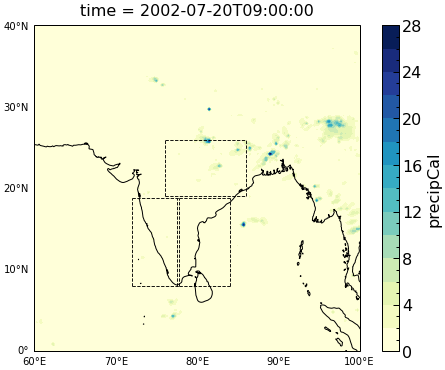

In [49]:
# fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([59.9, 100.1, -0.1, 40.1], crs=ccrs.PlateCarree())
# marking wcgw
ax.plot([72, 72], [8, 18.75], 'k', ls = '--', lw = 0.9)
ax.plot([77.75, 77.75], [8, 18.75], 'k', ls = '--', lw = 0.9)
ax.plot([72, 77.75], [8, 8], 'k', ls = '--', lw=0.9)
ax.plot([72, 77.75], [18.75, 18.75], 'k', ls = '--', lw = 0.9)
# marking sip region
ax.plot([77.5, 77.5], [8, 18.75], 'k', ls = '--', lw = 0.9)
ax.plot([84, 84], [8, 18.75], 'k', ls = '--', lw = 0.9)
ax.plot([77.75, 84], [8, 8], 'k', ls = '--', lw=0.9)
ax.plot([77.75, 84], [18.75, 18.75], 'k', ls = '--', lw = 0.9)
# marking cir region
ax.plot([76, 76], [19, 26], 'k', ls = '--', lw = 0.9)
ax.plot([86, 86], [19, 26], 'k', ls = '--', lw = 0.9)
ax.plot([76, 86], [19, 19], 'k', ls = '--', lw=0.9)
ax.plot([76, 86], [26, 26], 'k', ls = '--', lw = 0.9)
ds_comb.precipCal.sel(time="2002-07-20 09:00:00").plot.contourf(ax = ax, extend='neither', levels=15)
# ax.coastlines(alpha=0.7)
gridliner = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.05, linestyle='--')
# ax.add_feature(cfeature.BORDERS, alpha=0.7)
ax.add_feature(cfeature.COASTLINE, alpha=1.0)
gridliner.top_labels = False
gridliner.right_labels = False
gridliner.ylines = False  # you need False
gridliner.xlines = False  # you need False
# ax.tick_params(axis='both', labelsize=12)
plt.savefig('./images/region.pdf', dpi=300)

**Getting the the monsoon data from all years**

In [50]:
mon = [6,7,8,9]
premon = [3,4,5]
postmon = [10,11,12]
wint = [1,2]

In [51]:
ds_comb_mon = xr.concat([list(ds_comb.groupby('time.month'))[i-1][1] for i in mon], dim='time')

In [52]:
ds_comb_mon

,Array,Chunk
Bytes,1.41 GiB,4.54 MiB
Shape,"(14640, 161, 161)","(744, 40, 40)"
Count,4022280 Tasks,550 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,1.41 GiB,4.54 MiB
Shape,"(14640, 161, 161)","(744, 40, 40)"
Count,1820 Tasks,550 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


**analysing**

In [53]:
precip = ds_comb_mon.precipCal
t2m = ds_comb_mon.t2m
d2m = ds_comb_mon.d2m

In [54]:
precip_daily_rate = precip[::-1].rolling(time=24).sum()[::-1]

In [55]:
# Set values less than 1 mm/hr to nan

precip = xr.where(precip_daily_rate > 1, precip, np.nan).chunk(dict(time=-1, lat=40, lon=40))
precip = precip.where(precip > 0).chunk(dict(time=-1, lat=40, lon=40))
# precip = xr.where(precip > 0.1, precip, np.nan).chunk(dict(time=-1, lat=40, lon=40))
t2m = t2m.where(precip != np.nan).chunk(dict(time=-1, lat=40, lon=40))
d2m = d2m.where(precip != np.nan).chunk(dict(time=-1, lat=40, lon=40))

In [48]:
# ds_comb_new = xr.merge([precip, t2m, d2m]).chunk(dict(time=-1, lat=40, lon=40))
# ds_comb_new

In [49]:
# ds_comb_new.unify_chunks()
# ds_comb_new.chunks

### India plots

In [56]:
# ind_precip = precip.chunk(dict(time=-1, lat=40, lon=40))
# ind_t2m = t2m.chunk(dict(time=-1, lat=40, lon=40))
# ind_d2m = d2m.chunk(dict(time=-1, lat=40, lon=40))

In [57]:
# wg.unify_chunks()
# wg_precip.chunks

In [58]:
# wg = wg.rename_vars({'precipCal':'precipitationCal'})

In [59]:
# del ds_comb
# del ds_comb_mon
# del mum

In [ ]:
ccscale95_t2m_slope, ccscale95_t2m_p, ccscale95_d2m_slope, ccscale95_d2m_p  = binning.get_binned_3d(precip, t2m, d2m, percentile_val=0.95, bin_nr=20)

In [ ]:
# ccscale50_t2m_slope, ccscale50_t2m_p, ccscale50_d2m_slope, ccscale50_d2m_p  = binning.get_binned_3d(ind_precip, ind_t2m, ind_d2m, percentile_val=0.50, bin_nr=20)

In [78]:
# # Plotting function -- Fpr India
# def ccplot_3d(slope_da, r_da, extent_list, title, threshold_sig=0.95, marker_size=2, **kwargs):
#     """
#     Function to plot the output of binning 3d function
#     -----
#     inputs are -
#     slope_da : datarray containing slope
#     r_da : datarray containing R^2 values for goodness of fit
#     title : The title of the output plot
#     extent_list : [59.9, 100.1, -0.1, 40.1]
#     """
#     ax = plt.axes(projection=ccrs.PlateCarree())
#     ax.set_extent(extent_list, crs=ccrs.PlateCarree())
#     (100*(np.exp(slope_da) - 1)).plot.contourf(ax = ax, cbar_kwargs={"label":"C-C scale"}, **kwargs)
# #     (100*(np.exp(slope_da) - 1)).plot.pcolormesh(ax = ax, cbar_kwargs={"label":"C-C scale"}, **kwargs)
#     x, y = np.meshgrid(slope_da.coords['lon'], slope_da.coords['lat'])
#     plt.scatter(x[(np.abs(r_da.to_numpy()) > threshold_sig)],y[(np.abs(r_da.to_numpy()) > threshold_sig)], marker='o', color = 'k', s=marker_size)
#     gridliner = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.05, linestyle='--')
#     # ax.coastlines(alpha=0.7)
#     # ax.add_feature(cfeature.BORDERS, alpha=0.7)
#     ax.add_feature(cfeature.COASTLINE, alpha=1.0)
#     gridliner.top_labels = False
#     gridliner.right_labels = False
#     gridliner.ylines = False  # you need False
#     gridliner.xlines = False  # you need False
#     ax.set_title(title)
#     # ax.set_xlabel('Latitude')
#     # ax.set_ylabel('Longitude')
#     # ax.tick_params(axis='both', labelsize=12)
# # ax.tick_params(axis='both', labelsize=12)

In [79]:
# Extent_lists
ind = [59.9, 100.1, -0.1, 40.1]
sip = [77.65, 84.1, 7.9, 18.85]
wcwg = [71.9, 77.15, 7.9, 18.85]
cir = [75.9, 86.1, 18.9, 26.1]

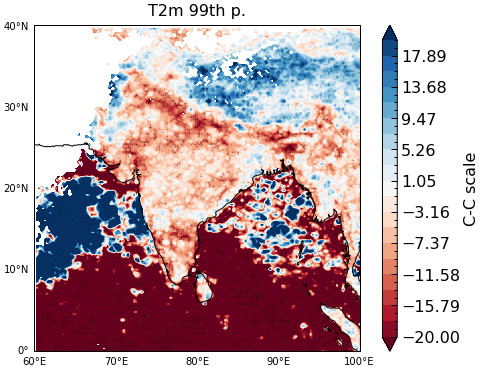

In [81]:
# India T2m 99th
ccplot_3d(ccscale95_t2m_slope, ccscale95_t2m_p, ind, 'T2m 95th p.', threshold_sig=0.8, marker_size=.02, levels=20, extend='both', vmax=20, center=0.0)
plt.savefig('./images/india_t2m95.pdf', dpi=300)

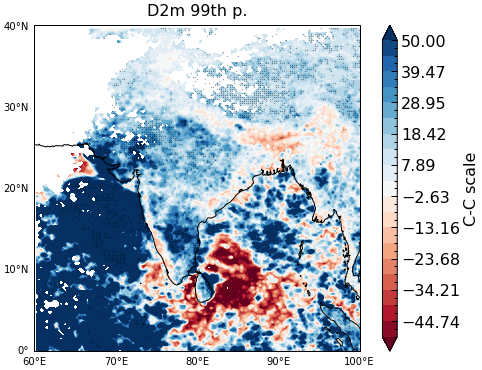

In [103]:
# Wester Ghats D2m 99th
ccplot_3d(ccscale95_d2m_slope, ccscale95_d2m_p, ind, 'D2m 95th p.', threshold_sig=0.8, marker_size=.02, levels=20, extend='both', vmax=50, center=0.0)
plt.savefig('./images/india_d2m95.pdf', dpi=300)

In [247]:
# ccscale50_t2m_slope, ccscale50_t2m_p, ccscale50_d2m_slope, ccscale50_d2m_p  = binning.get_binned_3d(wg_precip, wg_t2m, wg_d2m, percentile_val=0.50, bin_nr=20)

In [63]:
# # India T2m 50th
# ccplot.plot_3d(ccscale50_t2m_slope, ccscale50_t2m_p, 'WG T2m 50th p.', [73.65, 76.35, 9.9, 20.1], levels=20)
# plt.savefig('./images/wg_t2m50.pdf', dpi=300)

In [64]:
# # India D2m 50th
# ccplot.plot_3d(ccscale50_d2m_slope, ccscale50_d2m_p, 'WG D2m 50th p.',[73.65, 76.35, 9.9, 20.1], levels=20, vmin=-1, vmax=1.0, extend='max')
# plt.savefig('./images/wg_d2m50.pdf', dpi=300)

## SIP region

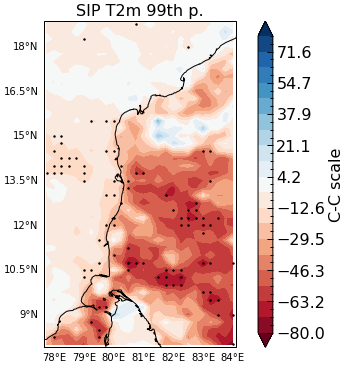

In [104]:
ccplot_3d(ccscale95_t2m_slope.sel(lat =slice(8,19), lon = slice(77.75,84)), ccscale95_t2m_p.sel(lat =slice(8,19), lon = slice(77.75,84)), sip, 'SIP T2m 95th p.', threshold_sig=0.8, marker_size=2, levels=20, extend='both', vmax=80, center=0.0)
plt.savefig('./images/sip_t2m95.pdf', dpi=300)

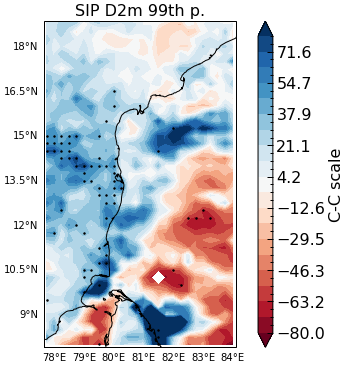

In [105]:
ccplot_3d(ccscale95_d2m_slope.sel(lat =slice(8,19), lon = slice(77.75,84)), ccscale95_d2m_p.sel(lat =slice(8,19), lon = slice(77.75,84)), sip, 'SIP D2m 95th p.', threshold_sig=0.8, marker_size=2, levels=20, extend='both', vmax=80, center=0.0)
plt.savefig('./images/sip_d2m95.pdf', dpi=300)

## WCWG region

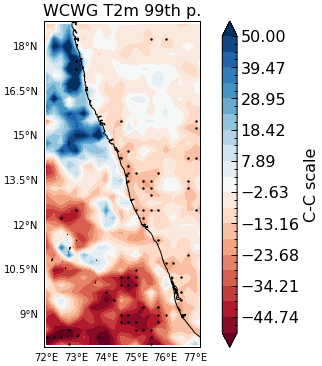

In [106]:
ccplot_3d(ccscale95_t2m_slope.sel(lat =slice(8,18.75), lon = slice(72,77.5)), ccscale95_t2m_p.sel(lat =slice(8,18.75), lon = slice(72,77.5)), wcwg, 'WCWG T2m 95th p.', threshold_sig=0.8, marker_size=2, levels=20, extend='both', vmax=50, center=0.0)
plt.savefig('./images/wcwg_t2m95.pdf', dpi=300)

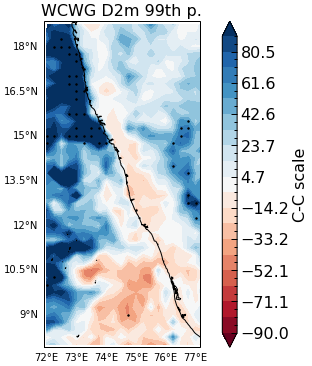

In [107]:
ccplot_3d(ccscale95_d2m_slope.sel(lat =slice(8,18.75), lon = slice(72,77.5)), ccscale95_d2m_p.sel(lat =slice(8,18.75), lon = slice(72,77.5)), wcwg, 'WCWG D2m 95th p.', threshold_sig=0.8, marker_size=2, levels=20, extend='both', vmax=90, center=0.0)
plt.savefig('./images/wcwg_d2m95.pdf', dpi=300)

## CIR region

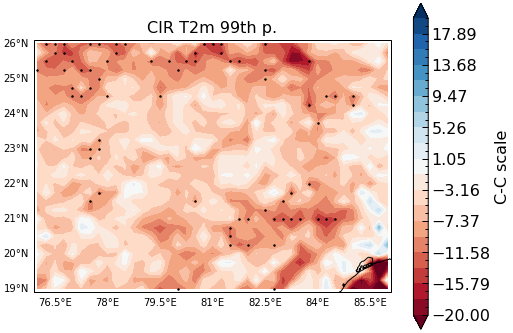

In [110]:
ccplot_3d(ccscale95_t2m_slope.sel(lat =slice(19,26), lon = slice(76,86)), ccscale95_t2m_p.sel(lat =slice(19,26), lon = slice(76,86)), cir, 'CIR T2m 95th p.', threshold_sig=0.8, marker_size=2, levels=20, extend='both', vmax=20, center=0.0)
plt.savefig('./images/cir_t2m95.pdf', dpi=300)

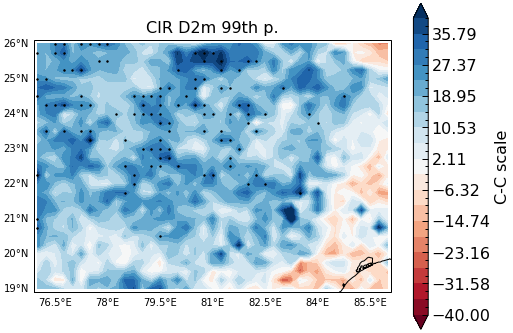

In [116]:
ccplot_3d(ccscale95_d2m_slope.sel(lat =slice(19,26), lon = slice(76,86)), ccscale95_d2m_p.sel(lat =slice(19,26), lon = slice(76,86)), cir, 'CIR D2m 95th p.', threshold_sig=0.8, marker_size=2, levels=20, extend='both', vmax=40, center=0.0)
plt.savefig('./images/cir_d2m95.pdf', dpi=300)

### Western Ghats

In [15]:
# Western Ghats mean
# mum = ds_comb_new.sel(lat=slice(10,20), lon = slice(73.75,76.25)).mean(dim = ['lat', 'lon'])
precip_wg = precip.sel(lat=slice(10,20), lon = slice(73.75,76.25)).mean(dim = ['lat', 'lon'])
t2m_wg = t2m.sel(lat=slice(10,20), lon = slice(73.75,76.25)).mean(dim = ['lat', 'lon'])
d2m_wg = d2m.sel(lat=slice(10,20), lon = slice(73.75,76.25)).mean(dim = ['lat', 'lon'])

In [16]:
# mum.chunks

In [17]:
binned_precip99_t2m, mean_temp99_t2m = binning.get_binned(precip_wg, t2m_wg, percentile_val=0.99, bin_nr=20)
binned_precip50_t2m, mean_temp50_t2m = binning.get_binned(precip_wg, t2m_wg, percentile_val=0.50, bin_nr=20)

In [18]:
binned_precip99_d2m, mean_temp99_d2m = binning.get_binned(precip_wg, d2m_wg, percentile_val=0.99, bin_nr=20)
binned_precip50_d2m, mean_temp50_d2m = binning.get_binned(precip_wg, d2m_wg, percentile_val=0.50, bin_nr=20)

In [19]:
binned_precip50_d2m

<xarray.DataArray 'precipCal' (d2m_bins: 20)>
dask.array<getitem, shape=(20,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * d2m_bins  (d2m_bins) object (291.70220947260003, 294.5432434082] ... (296...
    quantile  float64 0.5

In [20]:
# for t2m
temparr99, preciparr1_99, preciparr2_99 = ccplot.get_ideal_data(mean_temp99_t2m, 0.1, 1, time_scale=1)
temparr50, preciparr1_50, preciparr2_50 = ccplot.get_ideal_data(mean_temp50_t2m, 0.1, 1, time_scale=1)

In [21]:
# for t2m
temparr99, preciparr3_99, preciparr4_99 = ccplot.get_ideal_data(mean_temp99_t2m, 0.0001, 0.001, time_scale=2)
temparr50, preciparr3_50, preciparr4_50 = ccplot.get_ideal_data(mean_temp50_t2m, 0.0001, 0.001, time_scale=2)

In [24]:
# for d2m
temparr99, preciparr1_99, preciparr2_99 = ccplot.get_ideal_data(mean_temp99_d2m, 0.1, 1, time_scale=1)
temparr50, preciparr1_50, preciparr2_50 = ccplot.get_ideal_data(mean_temp50_d2m, 0.01, 0.1, time_scale=1)

In [25]:
# for d2m
temparr99, preciparr3_99, preciparr4_99 = ccplot.get_ideal_data(mean_temp99_d2m, 0.0001, 0.001, time_scale=2)
temparr50, preciparr3_50, preciparr4_50 = ccplot.get_ideal_data(mean_temp50_d2m, 0.0001, 0.001, time_scale=2)

In [22]:
# binned_ds99 = binned_ds99.rename_vars({'precipCal':'precipitationCal'})
# binned_ds50 = binned_ds50.rename_vars({'precipCal':'precipitationCal'})

/home/nkv/.miniconda/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/nkv/.miniconda/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


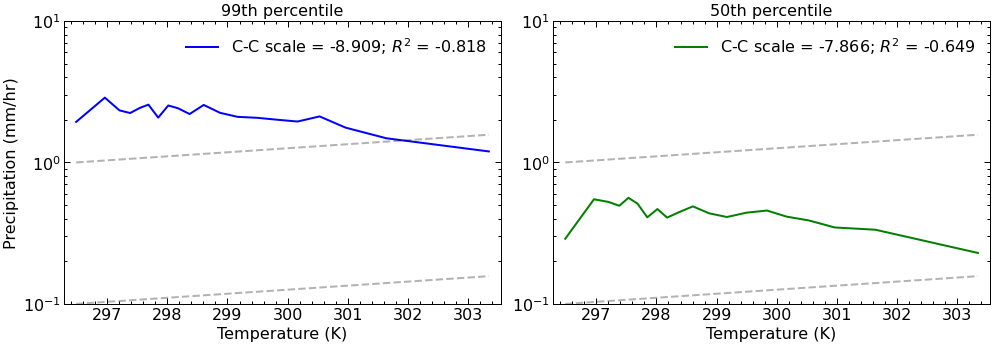

In [23]:
fig = plt.figure(figsize=(14,5))

plt.subplot(121)
ccplot.plot(binned_precip99_t2m, mean_temp99_t2m, temparr99, preciparr1_99, preciparr2_99, preciparr3_99, preciparr4_99, fit=False, color = 'blue')
plt.ylabel('Precipitation (mm/hr)')
plt.xlabel('Temperature (K)')
plt.title('99th percentile')
plt.ylim(0.1, 10)
plt.yticks([0.1, 1, 10])

# fig.gca().yaxis.set_ticks_position('both')

plt.subplot(122)
ccplot.plot(binned_precip50_t2m, mean_temp50_t2m, temparr50, preciparr1_50, preciparr2_50, preciparr3_50, preciparr4_50, fit=False, color = 'green')

# plt.ylabel('Precipitation (mm/hr)')
plt.xlabel('Temperature (K)')
plt.title('50th percentile')
plt.ylim(0.1, 10)
plt.yticks([0.1, 1, 10])

# fig.gca().yaxis.set_ticks_position('both')
fig.tight_layout()
plt.savefig('./images/mumbai_ccplot_t2m.pdf', dpi = 300)

/home/nkv/.miniconda/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/nkv/.miniconda/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


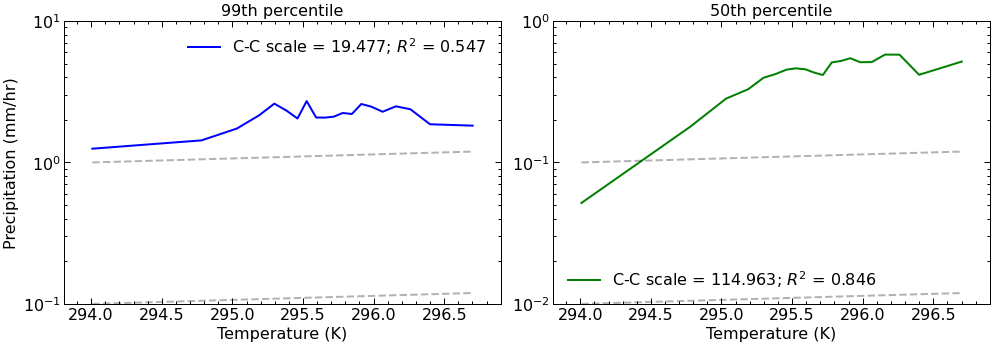

In [27]:
fig = plt.figure(figsize=(14,5))

plt.subplot(121)
ccplot.plot(binned_precip99_d2m, mean_temp99_d2m, temparr99, preciparr1_99, preciparr2_99, preciparr3_99, preciparr4_99, fit=False, color = 'blue')
plt.ylabel('Precipitation (mm/hr)')
plt.xlabel('Temperature (K)')
plt.title('99th percentile')
plt.ylim(0.1, 10)
plt.yticks([0.1, 1, 10])

# fig.gca().yaxis.set_ticks_position('both')

plt.subplot(122)
ccplot.plot(binned_precip50_d2m, mean_temp50_d2m, temparr50, preciparr1_50, preciparr2_50, preciparr3_50, preciparr4_50, fit=False, color = 'green')

# plt.ylabel('Precipitation (mm/hr)')
plt.xlabel('Temperature (K)')
plt.title('50th percentile')
plt.ylim(0.01, 1)
plt.yticks([0.01, 0.1, 1])

# fig.gca().yaxis.set_ticks_position('both')
fig.tight_layout()
plt.savefig('./images/mumbai_ccplot_d2m.pdf', dpi = 300)

In [15]:
wg_precip = precip.sel(lat = slice(10, 20), lon = slice(73.75, 76.25)).chunk(dict(time=-1, lat=-1, lon=-1))
wg_t2m = t2m.sel(lat = slice(10, 20), lon = slice(73.75, 76.25)).chunk(dict(time=-1, lat=-1, lon=-1))
wg_d2m = d2m.sel(lat = slice(10, 20), lon = slice(73.75, 76.25)).chunk(dict(time=-1, lat=-1, lon=-1))

In [16]:
# wg.unify_chunks()
# wg_precip.chunks

In [17]:
# wg = wg.rename_vars({'precipCal':'precipitationCal'})

In [18]:
# del ds_comb
# del ds_comb_mon
# del mum

In [19]:
wg_d2m

<xarray.DataArray 'd2m' (time: 8784, lat: 41, lon: 11)>
dask.array<rechunk-merge, shape=(8784, 41, 11), dtype=float32, chunksize=(8784, 41, 11), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 73.75 74.0 74.25 74.5 74.75 ... 75.5 75.75 76.0 76.25
  * lat      (lat) float64 10.0 10.25 10.5 10.75 11.0 ... 19.25 19.5 19.75 20.0
  * time     (time) datetime64[ns] 2017-06-01 ... 2019-09-30T23:00:00
Attributes:
    units:      K
    long_name:  2 metre dewpoint temperature

In [20]:
ccscale99_t2m_slope, ccscale99_t2m_p, ccscale99_d2m_slope, ccscale99_d2m_p  = binning.get_binned_3d_alter(wg_precip, wg_t2m, wg_d2m, percentile_val=0.99, bin_nr=20)

ValueError: too many values to unpack (expected 2)

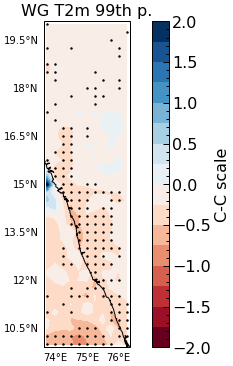

In [35]:
# Wester Ghats T2m 99th
ccplot.plot_3d(ccscale99_t2m_slope, ccscale99_t2m_p, 'WG T2m 99th p.', [73.65, 76.35, 9.9, 20.1], levels=20)
plt.savefig('./images/wg_t2m99.pdf', dpi=300)

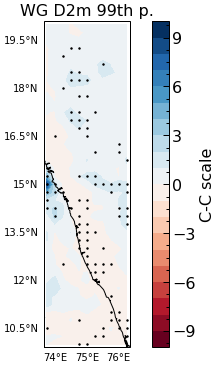

In [36]:
# Wester Ghats D2m 99th
ccplot.plot_3d(ccscale99_d2m_slope, ccscale99_d2m_p, 'WG D2m 99th p.', [73.65, 76.35, 9.9, 20.1], levels=20)
plt.savefig('./images/wg_d2m99.pdf', dpi=300)

In [37]:
ccscale50_t2m_slope, ccscale50_t2m_p, ccscale50_d2m_slope, ccscale50_d2m_p  = binning.get_binned_3d(wg_precip, wg_t2m, wg_d2m, percentile_val=0.50, bin_nr=20)

/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in l

/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in l

/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in l

/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in l

/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in l

/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in l

/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in l

/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in l

/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in l

/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in l

/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in l

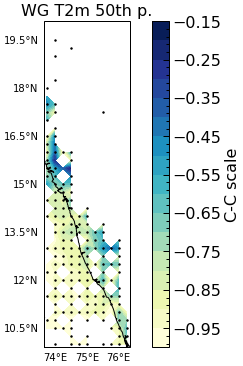

In [38]:
# Wester Ghats T2m 50th
ccplot.plot_3d(ccscale50_t2m_slope, ccscale50_t2m_p, 'WG T2m 50th p.', [73.65, 76.35, 9.9, 20.1], levels=20)
plt.savefig('./images/wg_t2m50.pdf', dpi=300)

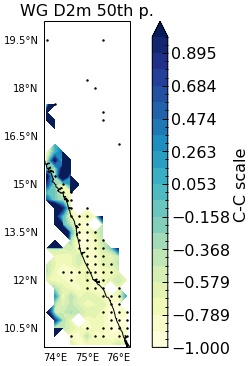

In [39]:
# Wester Ghats D2m 50th
ccplot.plot_3d(ccscale50_d2m_slope, ccscale50_d2m_p, 'WG D2m 50th p.',[73.65, 76.35, 9.9, 20.1], levels=20, vmin=-1, vmax=1.0, extend='max')
plt.savefig('./images/wg_d2m50.pdf', dpi=300)